# Files d'attente - Projet épidémiologie
# Arnaud Capitan

___

Dans ce rendu, l'objectif est de voir les différences entre le modèle markovien et le modèle déterministe de la diffusion d'une épidémie.

#### $\underline{\text{Ce qu'il faut faire :}}$

1] Résoudre et afficher le système déterministe SIR (Susceptibles, Infectieux, Retirés) en prenant en entrée les paramètres $\beta$ et $\gamma$

2] Simuler l'évolution du processus de Markov pour une populaiton de N individus avec les mêmes paramètres $\beta$ et $\gamma$

3] Trouver des couples $(\beta,\gamma)$ pour lesquels :

 - Tout le monde est retiré sur le long terme

 - Il y a une partie de la population qui reste susceptible et une autre retirée

4] Illustrer sur des graphiques la convergence du processus de Markov renormalisé vers la solution du système déterministe

5] Question ouverte : comment estimer les paramètres $\beta$ et $\gamma$ sur un département donné à partir des données de Santé Publique France sur chaque département ?

___

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#### Note avant de commencer :

Tout au long de ce compte-rendu, pour la génération de toutes nos variables aléatoires, nous ne nous servirons que de $\textit{np.random.uniform(0,1)}$ comme il était indiqué dans le cours. Nous nous créons donc nos propres générateurs de variables aléatoires pour les différentes simulations (simulation aléatoire puis Markovienne) du modèle SIR.

___

### Partie 1 : Résolution du système déterministe SIR

Le système déterministe SIR (Susceptibles, Infectieux, Retirés) se modélise par le système différentiel de fonctions, $\forall t \in \textbf{R}_+$

 - $s(t) \geq 0$ la population de susceptibles
 - $i(t) \geq 0$ la population d'infectieux
 - $r(t) \geq 0$ la population de retirés

Avec :

 - s(0) = N, population initiale
 - i(0) = 1, patient zéro
 - r(0) = 0

Il se distingue du modèle Markovien en considérant que les passages susceptibles - infectieux et infectieux - retirés ne sont pas régis pas des variables aléatoires mais par des équations exactes dont tous les paramètres sont prédéfinis, avec $\beta$ le taux d'infection et $\gamma$ le taux de passage 'infectieux - retirés', qui peut correspondre à la fois à de la rémission, la mort du contaminé ou une combinaison des durées moyennes des deux.

Le système d'équation est le suivant :

 - $s(t) + i(t) + r(t) = m > 0$  $\forall t \geq 0$
 - $s'(t) = -\beta s(t) i(t)$
 - $i'(t) = \beta s(t) i(t) - \gamma i(t)$
 - $r'(t) = \gamma i(t)$

On remarque que le système n'évolue plus si et seulement si $i(t) = 0$, mais cela peut à la fois correspondre au fait que tout le monde soit passé du stade susceptible au stade retiré, ou alors la propagation s'est arrêtée avant d'avoir atteint toute la population.

In [3]:
s = 10000
i = 1
r = 0

Pour la résolution numérique du système déterministe, nous allons utiliser la méthode d'Euler avec un pas très faible pour garantir la stabilité de la méthode.

Cette méthode donnera des résultats à valeurs réelles, et ne correspond donc pas à une modélisation SIR pour une population (valeurs entières). Nous allons donc normaliser les valeurs s, i et r pour obtenir des pourcentages, et résoudre le système d'équations différentielles avec ces valeurs normalisées. Les valeurs entières s'obtiennent alors en prenant la partie entière du pourcentage multiplié par la population (qui correspond au coefficient de normalisation).

In [4]:
m = s + i + r
s /= m
i /= m
r /= m

In [5]:
def df(s,i,beta,gamma):
    ds_dt = -beta*s*i
    di_dt = beta*s*i - gamma*i
    dr_dt = gamma*i
    return(ds_dt,di_dt,dr_dt)

def euler(s,i,r,beta,gamma,dt):
    dsir_dt = df(s,i,beta,gamma)
    s += dt*dsir_dt[0]
    i += dt*dsir_dt[1]
    r += dt*dsir_dt[2]
    return(s,i,r)       

Pour notre condition d'arrêt, nous nous arrêtons si le système n'évolue plus, c'est-à-dire si la valeur réelle de $i(t)$ devient inférieure à 1.

In [6]:
def resolution_euler_deterministe(s,i,r,beta,gamma,dt):
    liste_s = [s]
    liste_i = [i]
    liste_r = [r]
    temps = [0]
    while m*i >= 1:
        s,i,r = euler(s,i,r,beta,gamma,dt)
        liste_s.append(s)
        liste_i.append(i)
        liste_r.append(r)
        temps.append(temps[-1]+dt)
    return(liste_s,liste_i,liste_r,temps)       

Il ne reste plus qu'à considérer les valeurs $\beta$, $\gamma$, et le pas de temps $dt$ pour la résolution du système.

___

Pour l'exemple, nous allons d'abord considérer une maladie très infectieuse qui ne tue pas et dont la rémission est longue. On peut prendre ainsi $\beta = 0.4$ et $\gamma = 0.1$

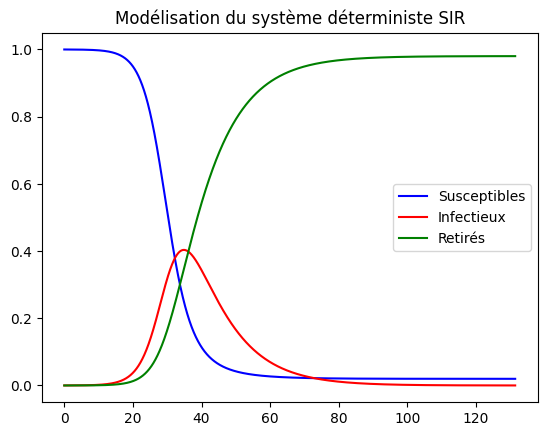

In [7]:
beta = 0.4
gamma = 0.1
dt = 0.001

liste_s,liste_i,liste_r,liste_temps = resolution_euler_deterministe(s,i,r,beta,gamma,dt)

plt.plot(liste_temps,liste_s,label='Susceptibles',color='b')
plt.plot(liste_temps,liste_i,label='Infectieux',color='r')
plt.plot(liste_temps,liste_r,label='Retirés',color='g')
plt.legend()
plt.title("Modélisation du système déterministe SIR")
plt.show()

___

### Partie 1 bis : Simulation SIR avec processus aléatoires

On considère une population de taille N+1, avec initialement :

 - $S = N$ susceptibles
 - $I = 1$ infecté
 - $R = 0$ retiré de la maladie 

Pour la propagation de l'épidémie, on considère que chaque infecté rencontre un individu aux instants d'un processus de Poisson d'intensité $\beta$.

Si l'individu recontré est susceptible, alors il devient infecté sinon il ne se passe rien. Les processus de rencontre sont indépendants, et les durées d'infection sont i.i.d de fonction de répartition $F_{\textit{I}}$

___

On rappelle par le cours que les instants $T_n$ d'un processus de Poisson d'intensité $\beta$ sont modélisés à l'aide de lois exponentielles $\xi _n \sim \text{Exp} (\beta)$ i.i.d. avec :

$T_0 = 0$

$T_n = \sum _{k=1} ^n \xi _k $ pour $n \geq 1$

On peut de plus simuler une loi exponentielle $\xi$ à l'aide d'une loi uniforme.

En effet, pour :

$ U \sim  \mathcal{U}([0,1]) $ 

$ V = -\frac{1}{\beta}\ln (U) $

Alors $V \sim  \text{Exp} (\beta)$

In [8]:
def loi_exponentielle(param):
    U = np.random.uniform(0,1)
    return(-np.log(U)/param)

def lois_exponentielles(param,n):
    Us = []
    for i in range(n):
        Us.append(loi_exponentielle(param))
    return(min(Us))

def loi_uniforme(N): #Génère un nombre aléatoire entre 1 et N inclus
    U = np.random.uniform(0,1)
    return(int(np.floor(U*N)+1))

Les intervalles de temps pendant lesquels les infectieux restent infectieux sont modélisés par des lois exponentielles de paramètre $\gamma$, et la durée pendant laquelle le malade $n$ reste contagieux est notée $\mathcal{I}_n$.

Nous faisons le choix de modéliser ce modèle à l'aide de dictionnaire pour chaque individu du modèle. Tout individu aura un statut (S,I,R), l'instant de contamination, un temps d'infectiosité (loi exponentielle de paramètre $\gamma$), et les instants de contamination (loi Poisson de paramètre $\beta$, dont les instants sont modélisés par des lois exponentielles de paramètre $\beta$, voir l'explication plus haut).

In [9]:
def init_population(N):
    population = dict()
    for i in range(N): #Déclaration de tous les individus du modèle
        population[i] = {"Statut":"S","Temps de contamination":None,"Durée":None}    
    return(population)

Avant de faire la déclaration du patient 0, nous créons une fonction qui permet de gérer la contamination par un individu infectieux.

In [10]:
def contamination(population,indice,temps,gamma):
    if population[indice]["Statut"] in ["I","R"]:
        return(population) # Cas du fantôme
    population[indice]["Statut"] = "I" # Cas du susceptible qui se fait infecter
    population[indice]["Temps de contamination"] = temps
    duree = loi_exponentielle(gamma)
    population[indice]["Durée"] = duree
    return(population)

def comptage_SIR(population,temps):
    s = 0
    i = 0
    r = 0
    for elem in population:
        if population[elem]["Statut"] == "S":
            s+=1
        if population[elem]["Statut"] == "I":
            if (population[elem]["Temps de contamination"] + population[elem]["Durée"] > temps):
                i+=1
            else :
                population[elem]["Statut"] = "R"
                r+=1
        elif population[elem]["Statut"] == "R":
            r+=1
    return(population,[s,i,r])

La fonction comptage_SIR permet d'actualiser tous les individus du stade infectieux au stade retiré à l'aide de la variable temps, et renvoie aussi les valeurs du nombre de S-I-R pour tracer les graphes.

In [11]:
# Déclaration du patient zéro
def patient_zero(population):
    population[0]["Statut"] = "I"
    population[0]["Temps de contamination"] = 0
    duree = loi_exponentielle(gamma)
    population[0]["Durée"] = duree
    return(population)

On peut maintenant lancer la simulation, en considérant que les individus rencontrés sont choisis uniformément sur {$1,...,N$}. On retrouve la notion de fantôme dans le polycopié, un infectieux choisi pour la deuxième fois au moins, mais cela ne change pas la simulation. La simulation s'arrête quand plus aucun patient n'est infectieux.

In [12]:
def simulation_SIR_aleatoire(N,beta,gamma):
    population = init_population(N+1)
    population = patient_zero(population)
    liste_S = [N]
    liste_I = [1]
    liste_R = [0]
    liste_T = [0]
    temps = 0
    while True:
        indice_aleatoire = loi_uniforme(N)
        population = contamination(population,indice_aleatoire,temps,gamma) #On contamine un individu
        population, sir = comptage_SIR(population,temps) #On actualise les infectieux -> retirés, et on récupère les différentes valeurs
        liste_S.append(sir[0])
        liste_I.append(sir[1])
        liste_R.append(sir[2])
        liste_T.append(temps)
        if sir[1] == 0:
            break
        temps += lois_exponentielles(beta,sir[1]) #On modélise le prochain temps d'itneraction par le minimum entre les lois exponentielles pour chaque individu infectieux
    return(liste_S,liste_I,liste_R,liste_T)


Note :
 - indice_aleatoire = loi_uniforme(N) : On peut considérer que le patient qui contamine à son instant de contamination est "à la place" du patient zéro, sinon on l'échange pour échanger son numéro à la place avec 0

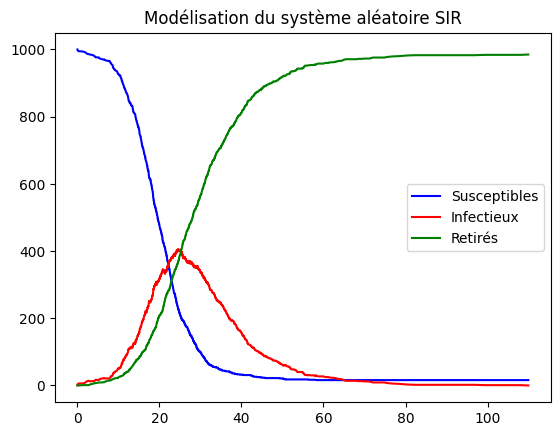

In [13]:
liste_S,liste_I,liste_R,liste_T = simulation_SIR_aleatoire(1000,beta,gamma)

plt.plot(liste_T,liste_S,label='Susceptibles',color='b')
plt.plot(liste_T,liste_I,label='Infectieux',color='r')
plt.plot(liste_T,liste_R,label='Retirés',color='g')
plt.legend()
plt.title("Modélisation du système aléatoire SIR")
plt.show()

Pour rappel, le système déterministe nous avait donné :

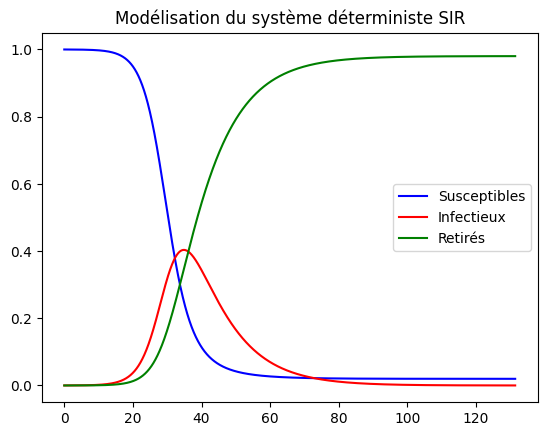

In [14]:
plt.plot(liste_temps,liste_s,label='Susceptibles',color='b')
plt.plot(liste_temps,liste_i,label='Infectieux',color='r')
plt.plot(liste_temps,liste_r,label='Retirés',color='g')
plt.legend()
plt.title("Modélisation du système déterministe SIR")
plt.show()

On obtient la même allure de courbe, ce qui est très satisfaisant et confirme la convergence du processus aléatoire vers la solution du système déterministe. En effet, la normalisation de l'axe des ordonnées ne changent pas l'allure de la courbe, nous avons obtenu le résultat souhaité.
___

### Partie 2 : Simulation SIR par modèle Markovien

On change la signification du paramètre $\beta$ qui désigne désormais le taux de rencontres avec des individus.

$\mathcal{I} \sim \text{Exp}(\gamma)$ correspond à la durée d'infectiosité

Contrairement au modèle aléatoire précédent, nous considérons des chaînes de transition, avec des taux (ou probabilités) selon lesquels la situation évolue, ou reste inchangée.

Nous partons ainsi de notre noeud initial, avec $S = N$, $I = 1$, $R = 0$.

A chaque étape, on calcule les taux d'infection et de guérison/mort en fonction des valeurs de S, I et R :

 - $\tau _{\text{infection}} = \beta \frac{SI}{N}$
 - $\tau _{\text{retire}} = \gamma I$

Comme pour la modélisation aléatoire précédente, on calcule les instants de changement d'état, mais cette fois-ci à partir de ces taux. Si l'on suppose que les processus d'infection et de guérison/mort sont indépendants, et sont des processus de Poisson de paramètre respectif les taux calculés juste au-dessus, on obtient alors une loi de Poisson de paramètre $\tau _{\text{infection}} + \tau _{\text{retire}}$ dont les instants sont modélisés par des lois exponentielles de paramètre $\tau _{\text{infection}} + \tau _{\text{retire}}$ d'après le cours (même principe que pour la simulation aléatoire).

___

#### Preuve :

Le prochain temps "d'événement" à l'étape n est obtenu par :

$T_{n+1} \sim min(\text{Exp}(\tau _{\text{infection}}),\text{Exp}(\tau _{\text{retire}}))$

D'après le cours, on a :

$ min(\text{Exp}(\tau _{\text{infection}}),\text{Exp}(\tau _{\text{retire}})) \sim \text{Exp}(\tau _{\text{infection}} + \tau _{\text{retire}})$

Donc :

$T_{n+1} \sim \text{Exp}(\tau _{\text{infection}} + \tau _{\text{retire}})$

___

On en profite pour montrer le résultat indiqué dans le cours :

Soit $X \sim \text{Exp}(\beta)$, $Y \sim \text{Exp}(\gamma)$, $X \perp\!\!\!\perp Y$, $U = min(X,Y)$

$\forall t \geq 0$

$\mathbb{P}(U \leq t) = \mathbb{P}(min(X,Y) \leq t) = 1 - \mathbb{P}(min(X,Y) > t)$

Cette dernière condition ne se réalise que si à la fois X et Y sont supérieures à t. On en déduit que :

$\mathbb{P}(U \leq t) = 1 - \mathbb{P}(X > t, Y > t)$

Par indépendance :

$\mathbb{P}(U \leq t) = 1 - \mathbb{P}(X > t)\mathbb{P}(Y > t)$

$\mathbb{P}(U \leq t) = 1 - e^{\beta t}e^{\gamma t} = 1 - e^{(\beta + \gamma) t}$

Ce qui nous donne le résultat, car pour une loi exponentielle V de paramètre $\lambda$, on a :

$\mathbb{P}(V \leq t) = \int _0^t \lambda e^{-\lambda x} dx = 1 - e^{-\lambda t}$

___

Une fois que le prochain temps d'événement est généré, on peut soit avancer, soit on reculer dans le graphe de notre chaîne de Markov. Nous ne pouvons pas rester fixe.
Pour savoir quelle décision prendre, on génère une loi uniforme $U \sim  \mathcal{U}([0,1])$ et on regarde si :

$$ U < \frac{\tau _{\text{infection}}}{\tau _{\text{infection}} + \tau _{\text{retire}}} $$

Si cette inégalité est vérifiée, alors il y a propagation de l'infection, on avance dans le graphe. Sinon on recule, il y a guérison. Ces mouvements se font évidemment s'il est possible d'infecter ou de guérir. S'il n'y a plus personne à infecter, alors on n'avance pas.

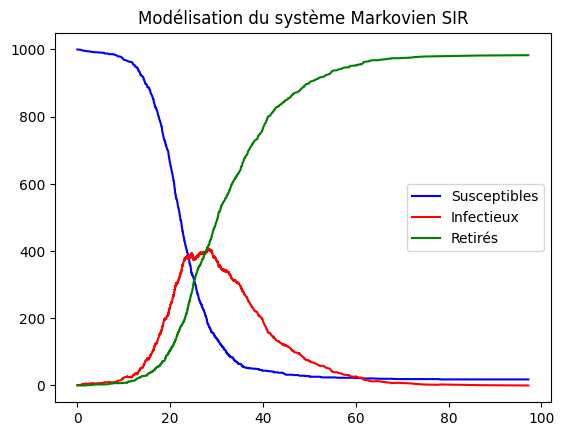

In [15]:
def simulation_markov(N,beta,gamma):
    S = N
    I = 1
    R = 0
    T = 0
    liste_T = [T]
    liste_S = [S]
    liste_I = [I]
    liste_R = [R]
    while I > 0:
        taux_infection = beta*S*I/N
        taux_retire = gamma*I
        t_prochain_evenement = loi_exponentielle(taux_infection+taux_retire) #Prochain temps pour n'importe quel événement, voir explication ci-dessus
        T += t_prochain_evenement
        U = np.random.uniform(0,1) 
        if np.random.rand() < taux_infection/(taux_infection+taux_retire):
            if S > 0: # Cas de l'infection, on avance dans le graphe, à condition que l'on puisse avancer
                S -= 1
                I += 1
        else:
            if I > 0: #Cas de la guérison, on recule dans le graphe, à condition que l'on puisse reculer (cette condition sera toujours vraie sinon la boucle while casse)
                I -= 1
                R += 1
        liste_T.append(T)
        liste_S.append(S)
        liste_I.append(I)
        liste_R.append(R)
    if len(liste_T) < 5:
        return(simulation_markov(N,beta,gamma))
    return(liste_S,liste_I,liste_R,liste_T)

liste_S,liste_I,liste_R,liste_T = simulation_markov(1000, beta, gamma)

plt.plot(liste_T,liste_S,label='Susceptibles',color='b')
plt.plot(liste_T,liste_I,label='Infectieux',color='r')
plt.plot(liste_T,liste_R,label='Retirés',color='g')
plt.legend()
plt.title("Modélisation du système Markovien SIR")
plt.show()


Parfois, on obtient un graphe avec uniquement des individus susceptibles et un retiré, c'est le cas où le patient zéro s'est rétabli avant d'avoir pu infecter qui que ce soit. Nous avons donc modifié la fonction pour garantir que l'épidémie "se lance" au moins un peu.

On obtient exactement les mêmes courbes que les deux autres modèles.
On peut aligner les 3 graphes :

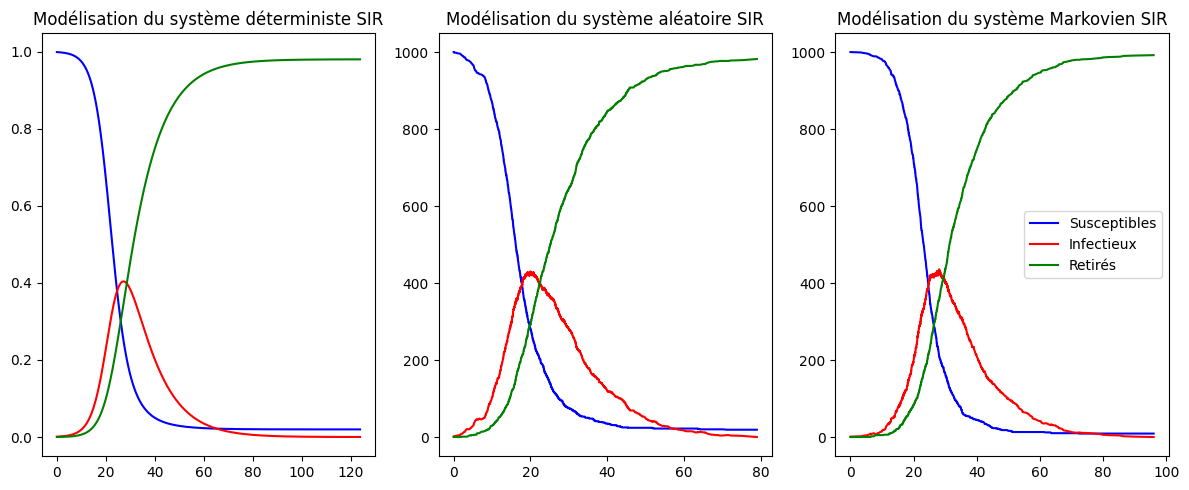

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

liste_s,liste_i,liste_r,liste_temps = resolution_euler_deterministe(1-1/1000,1/1000,0,beta,gamma,0.01)
axes[0].plot(liste_temps,liste_s,label='Susceptibles',color='b')
axes[0].plot(liste_temps,liste_i,label='Infectieux',color='r')
axes[0].plot(liste_temps,liste_r,label='Retirés',color='g')
axes[0].set_title("Modélisation du système déterministe SIR")

liste_S,liste_I,liste_R,liste_T = simulation_SIR_aleatoire(1000,beta,gamma)
axes[1].plot(liste_T,liste_S,label='Susceptibles',color='b')
axes[1].plot(liste_T,liste_I,label='Infectieux',color='r')
axes[1].plot(liste_T,liste_R,label='Retirés',color='g')
axes[1].set_title("Modélisation du système aléatoire SIR")

liste_S,liste_I,liste_R,liste_T = simulation_markov(1000,beta,gamma)
axes[2].plot(liste_T,liste_S,label='Susceptibles',color='b')
axes[2].plot(liste_T,liste_I,label='Infectieux',color='r')
axes[2].plot(liste_T,liste_R,label='Retirés',color='g')
axes[2].set_title("Modélisation du système Markovien SIR")

plt.legend()
plt.tight_layout()
plt.show()

___

### Partie 3 : Simulation SIR par modèle Markovien

On va maintenant donner des couples $(\beta,\gamma)$ pour lesquels :

 - Tout le monde est retiré sur le long terme

 - Il y a une partie de la population qui reste susceptible et une autre retirée

Il est facile en interprétant les coeffecients $\beta$ et $\gamma$ d'observer que si $\beta > \gamma$, alors il y aura en moyenne pour un infectieux plus d'une infection avant qu'il soit rétabli (ou mort), donc l'épidémie explose. A l'inverse, si $\beta \sim \gamma$, alors l'infection tue trop vite / se guérit trop rapidement pour qu'elle se propage correctement. Le pic d'épidémie est atteint très rapidement, et l'infection ne se propage plus en laissant une partie de la population non touchée.

Pour obtenir les situations souhaitées, on augmente les écarts entre les valeurs pour garantir le résultat attendu, donc respectivement $\beta >> \gamma$ et $\beta \sim \gamma$
Illustration :

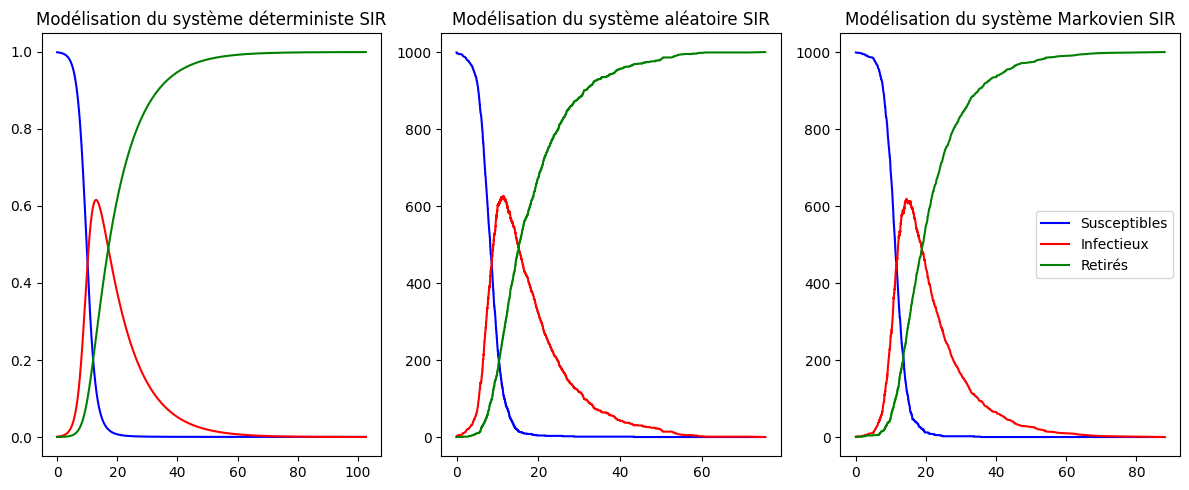

In [17]:
beta = 0.8
gamma = 0.1

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

liste_s,liste_i,liste_r,liste_temps = resolution_euler_deterministe(1-1/1000,1/1000,0,beta,gamma,0.01)
axes[0].plot(liste_temps,liste_s,label='Susceptibles',color='b')
axes[0].plot(liste_temps,liste_i,label='Infectieux',color='r')
axes[0].plot(liste_temps,liste_r,label='Retirés',color='g')
axes[0].set_title("Modélisation du système déterministe SIR")

liste_S,liste_I,liste_R,liste_T = simulation_SIR_aleatoire(1000,beta,gamma)
axes[1].plot(liste_T,liste_S,label='Susceptibles',color='b')
axes[1].plot(liste_T,liste_I,label='Infectieux',color='r')
axes[1].plot(liste_T,liste_R,label='Retirés',color='g')
axes[1].set_title("Modélisation du système aléatoire SIR")

liste_S,liste_I,liste_R,liste_T = simulation_markov(1000,beta,gamma)
axes[2].plot(liste_T,liste_S,label='Susceptibles',color='b')
axes[2].plot(liste_T,liste_I,label='Infectieux',color='r')
axes[2].plot(liste_T,liste_R,label='Retirés',color='g')
axes[2].set_title("Modélisation du système Markovien SIR")

plt.legend()
plt.tight_layout()
plt.show()

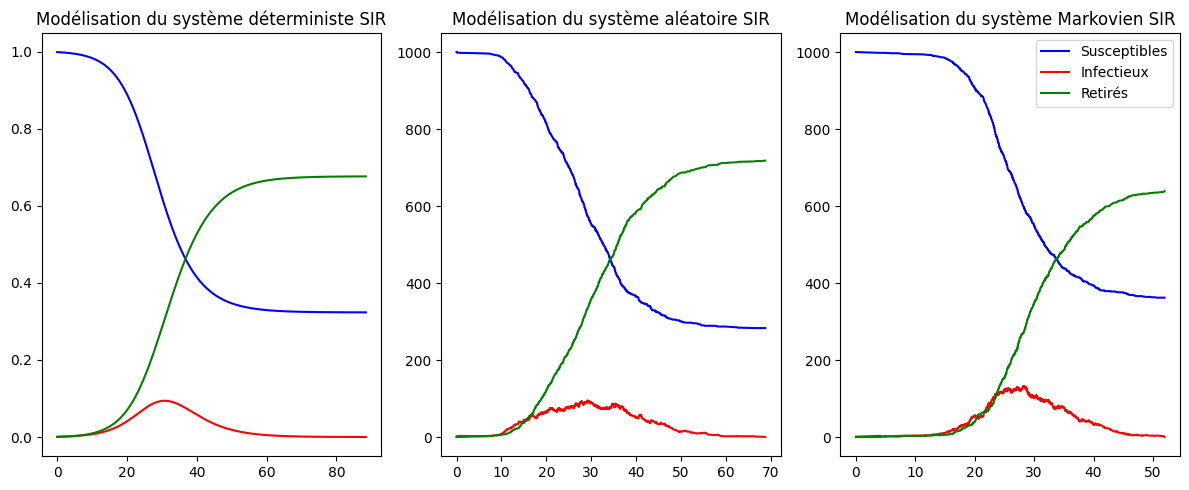

In [18]:
beta = 0.5
gamma = 0.3

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

liste_s,liste_i,liste_r,liste_temps = resolution_euler_deterministe(1-1/1000,1/1000,0,beta,gamma,0.01)
axes[0].plot(liste_temps,liste_s,label='Susceptibles',color='b')
axes[0].plot(liste_temps,liste_i,label='Infectieux',color='r')
axes[0].plot(liste_temps,liste_r,label='Retirés',color='g')
axes[0].set_title("Modélisation du système déterministe SIR")

liste_S,liste_I,liste_R,liste_T = simulation_SIR_aleatoire(1000,beta,gamma)
axes[1].plot(liste_T,liste_S,label='Susceptibles',color='b')
axes[1].plot(liste_T,liste_I,label='Infectieux',color='r')
axes[1].plot(liste_T,liste_R,label='Retirés',color='g')
axes[1].set_title("Modélisation du système aléatoire SIR")

liste_S,liste_I,liste_R,liste_T = simulation_markov(1000,beta,gamma)
axes[2].plot(liste_T,liste_S,label='Susceptibles',color='b')
axes[2].plot(liste_T,liste_I,label='Infectieux',color='r')
axes[2].plot(liste_T,liste_R,label='Retirés',color='g')
axes[2].set_title("Modélisation du système Markovien SIR")

plt.legend()
plt.tight_layout()
plt.show()

Couples $(\beta,\gamma)$ pour lesquels :

 - Tout le monde est retiré sur le long terme : $(\beta,\gamma) = (0.8,0.1)$

 - Il y a une partie de la population qui reste susceptible et une autre retirée $(\beta,\gamma) = (0.5,0.3)$

___

### Partie 4 : Convergence du processus de Markov renormalisé 

Dans cette partie, nous souhaitons illustré sur des graphiques la convergence du processus de Markov renormalisé vers la solution du système déterministe.
Nous allons donc, en gardant les paramètres $(\beta,\gamma)$ fixes modifier le paramètre N et observer la convergence du processus de Markov vers la solution déterministe.

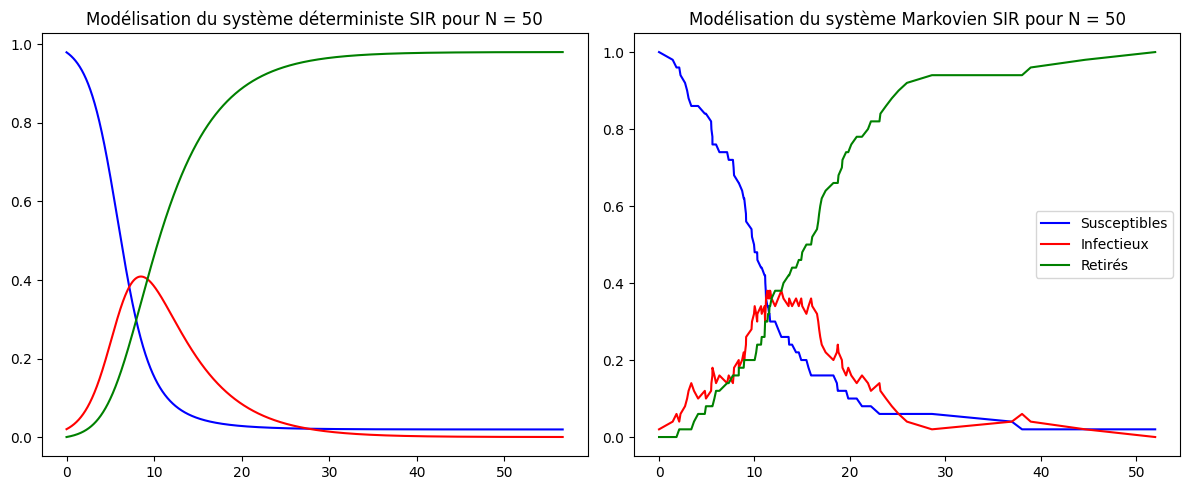

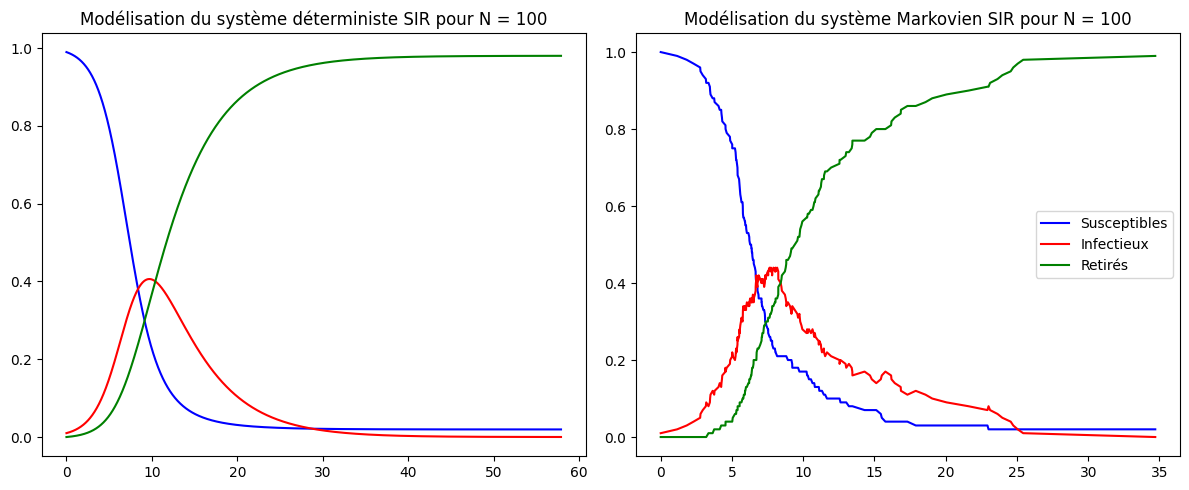

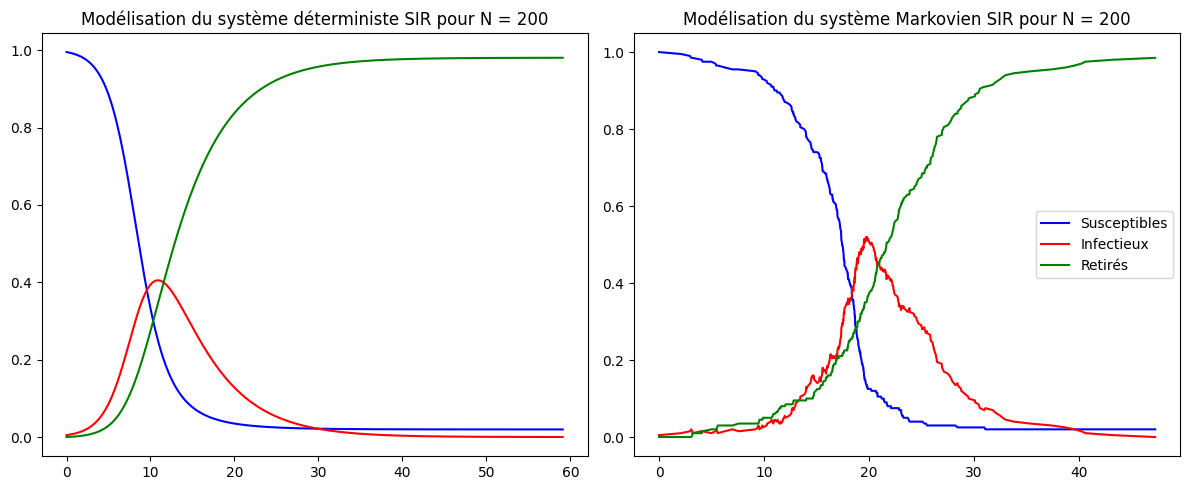

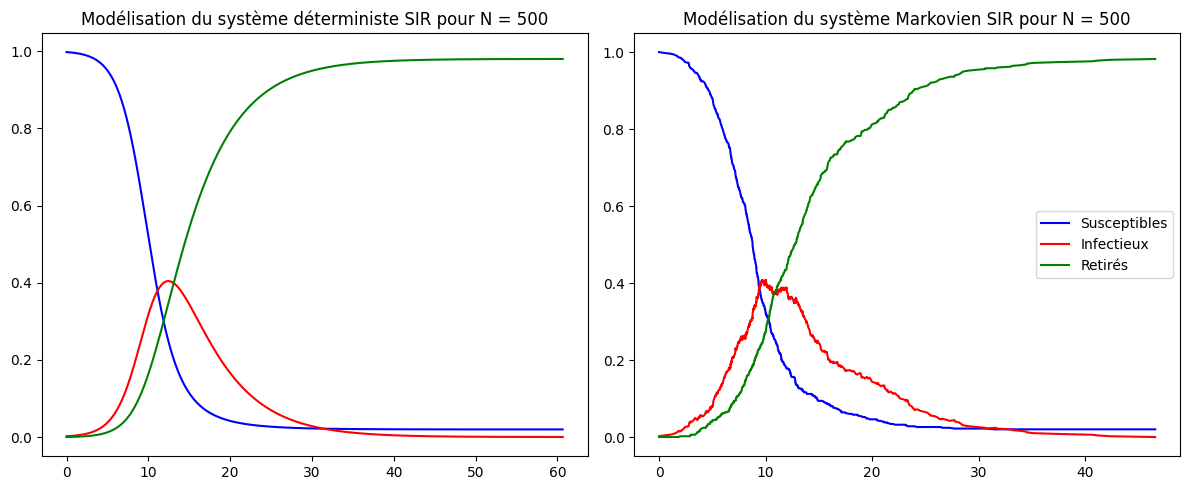

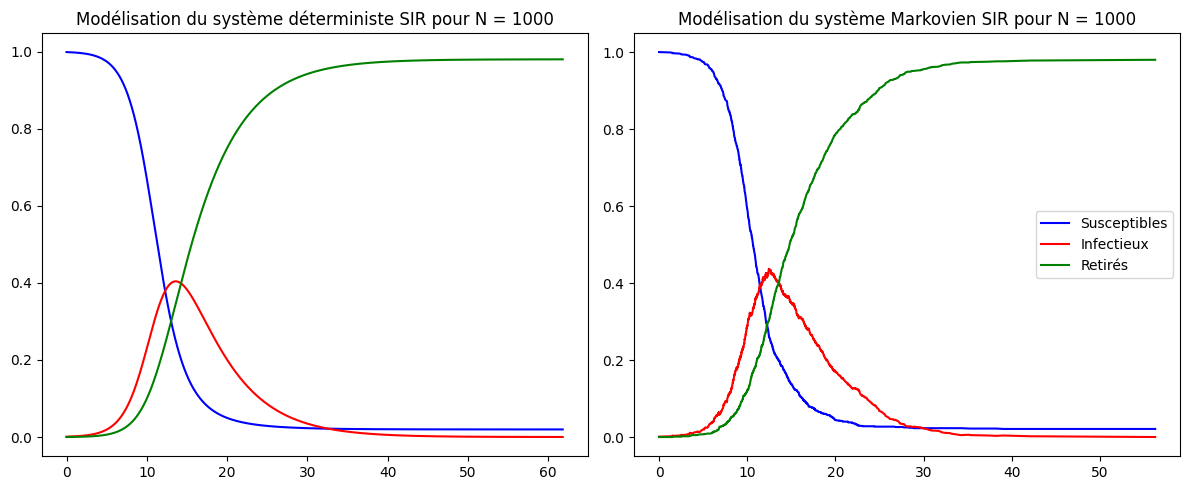

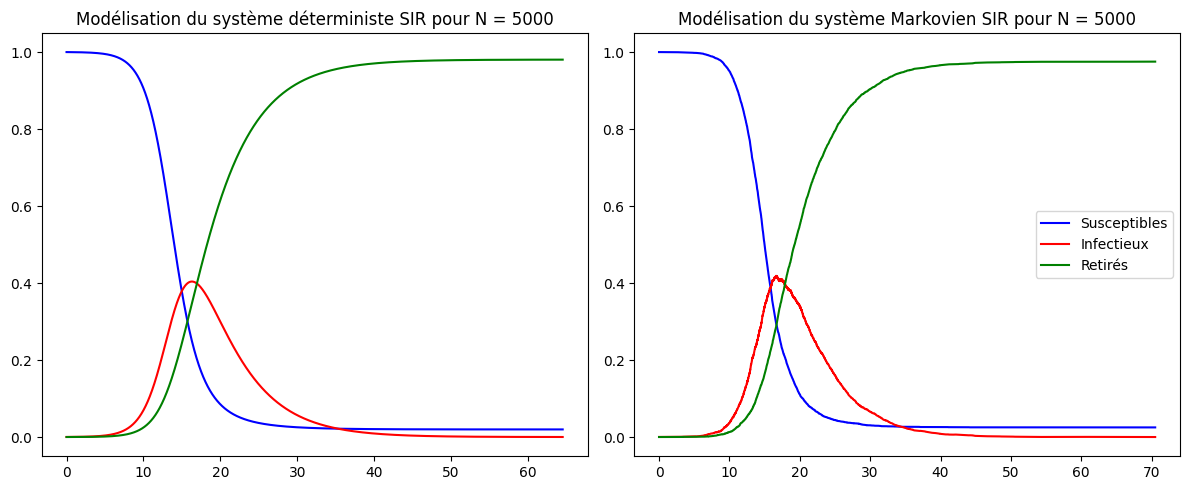

In [19]:
beta = 0.8
gamma = 0.2

for N in [50,100,200,500,1000,5000]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    liste_s,liste_i,liste_r,liste_temps = resolution_euler_deterministe(1-1/N,1/N,0,beta,gamma,0.01)
    axes[0].plot(liste_temps,liste_s,label='Susceptibles',color='b')
    axes[0].plot(liste_temps,liste_i,label='Infectieux',color='r')
    axes[0].plot(liste_temps,liste_r,label='Retirés',color='g')
    axes[0].set_title(f"Modélisation du système déterministe SIR pour N = {N}")
    liste_S,liste_I,liste_R,liste_T = simulation_markov(N,beta,gamma)
    liste_S = list(np.array(liste_S)/N)
    liste_I = list(np.array(liste_I)/N)
    liste_R = list(np.array(liste_R)/N)
    axes[1].plot(liste_T,liste_S,label='Susceptibles',color='b')
    axes[1].plot(liste_T,liste_I,label='Infectieux',color='r')
    axes[1].plot(liste_T,liste_R,label='Retirés',color='g')
    axes[1].set_title(f"Modélisation du système Markovien SIR pour N = {N}")
    plt.legend()
    plt.tight_layout()
    plt.show()

On a bien la convergence du système Markovien vers la solution déterministe pour N qui tend vers l'infini.

___

### Partie 5 : Question ouverte

Comment estimer les paramètres $\beta$ et $\gamma$ sur un département donné à partir des données de Santé Publique France sur chaque département ?

La bande dessinée donnée sur ce lien https://fivethirtyeight.com/features/a-comic-strip-tour-of-the-wild-world-of-pandemic-modeling/ explique bien les problématiques autour de l'estimation des différents paramètres.

Chaque département aura ses propres paramètres. Selon moi, on peut estimer les paramètres $\beta$ et $\gamma$ en regardant le pic d'épidémie, puis on étudie les coefficients approchant le mieux la décroissance (coefficient $\gamma$, taux de passage infectieux - retiré) après le pic, et la croissance avant le pic (coefficient $\beta$ de contamination).

Nous allons l'estimer sur le département Essonne et voir ce qu'il en est.

In [20]:
import csv

departement = []
date = []
hospitalisations = []
reanimations = []
morts = []
rad = []

with open('donnees-covid.csv',newline='',encoding='utf-8') as donnees:
    lecteur = csv.reader(donnees)
    next(lecteur)
    for ligne in lecteur:
        ligne = ligne[0].split(";")
        departement.append(ligne[0])
        date.append(ligne[1])
        hospitalisations.append(int(ligne[2]))
        reanimations.append(int(ligne[3]))
        morts.append(int(ligne[4]))
        rad.append(int(ligne[5]))

In [21]:
dictionnaire_departement = dict()
for elem in set(departement):
    hosp = []
    rea = []
    mort = []
    retour = []
    for i in range(len(departement)):
        if departement[i] == elem :
            hosp.append(hospitalisations[i])
            rea.append(reanimations[i])
            mort.append(morts[i])
            retour.append(rad[i])
    dictionnaire_departement[elem] = {"Dep":elem,"Hosp":hosp,"Rea":rea,"Morts":mort,"Rad":retour}

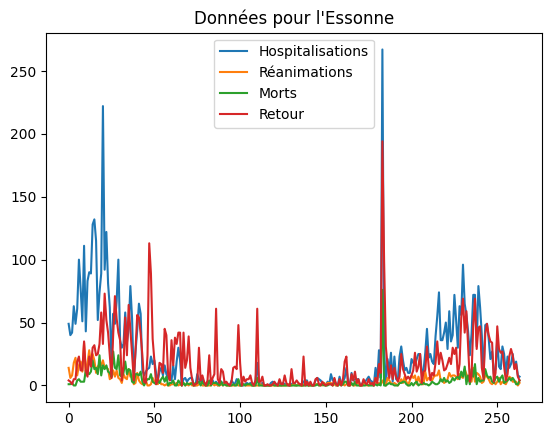

In [22]:
essonne = dictionnaire_departement['91']
t = [i for i in range(len(essonne["Hosp"]))]
plt.plot(t,essonne["Hosp"],label="Hospitalisations")
plt.plot(t,essonne["Rea"],label="Réanimations")
plt.plot(t,essonne["Morts"],label="Morts")
plt.plot(t,essonne["Rad"],label="Retour")
plt.title("Données pour l'Essonne")
plt.legend()
plt.show()

Puisque nous souhaitons avoir les données des infectieux et des retirés, nous allons additionner les données "Hospitalisations" et "Réanimations" ainsi que "Morts" et "Retour", pour obtenir respectivement "Infectieux" et "Retirés". Nous allons ensuite lissé les valeurs avec une moyenne glissante.

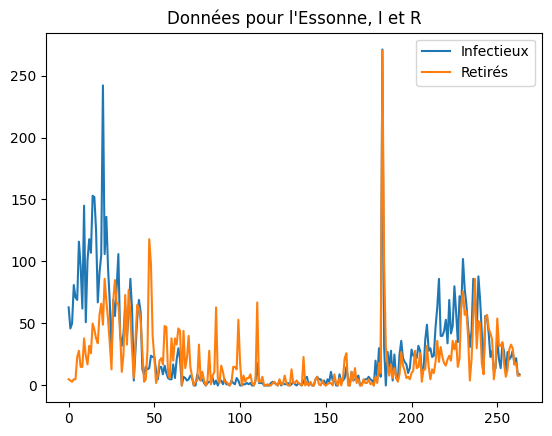

In [23]:
I = list(np.array(essonne["Hosp"]) + np.array(essonne["Rea"]))
R = list(np.array(essonne["Morts"]) + np.array(essonne["Rad"]))

plt.plot(t,I,label="Infectieux")
plt.plot(t,R,label="Retirés")
plt.title("Données pour l'Essonne, I et R")
plt.legend()
plt.show()

Le chiffre retiré correspond au nombre de personnes qui partent chaque jour de l'hôpital, donc on va sommer les valeurs pour obtenir le chiffre de retirés au cours du temps.

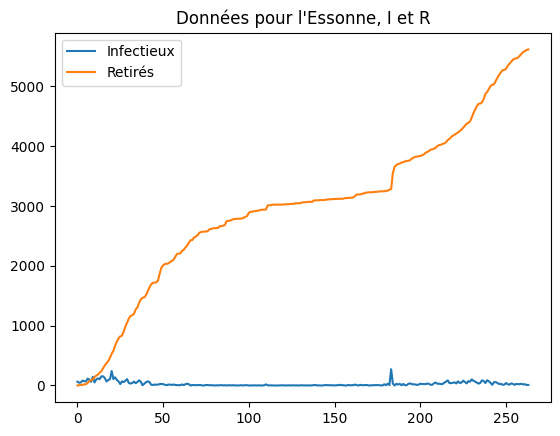

In [24]:
I = list(np.array(essonne["Hosp"]) + np.array(essonne["Rea"]))
R2 = []
for i in range(len(R)):
    R2.append(int(np.sum(R[:i])))

plt.plot(t,I,label="Infectieux")
plt.plot(t,R2,label="Retirés")
plt.title("Données pour l'Essonne, I et R")
plt.legend()
plt.show()

On remarque que sur la partie [55,150] on a une courbe qui ressemble fortement à une allure de $f(t) = 1 - e^{-\gamma t}$, on va donc estimer le coefficient $\gamma$ à partir de cette courbe.

On procédera de même avec $g(t) = e^{\beta t}$ pour le début de la courbe des infectieux.

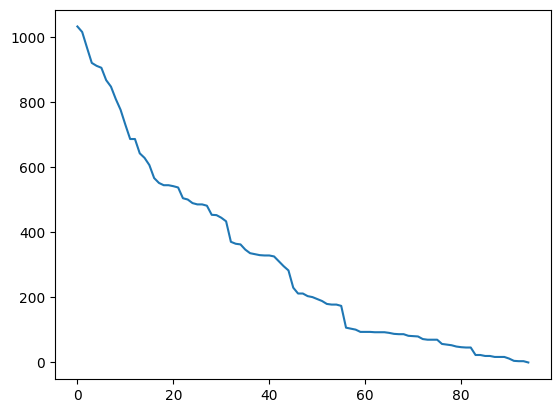

In [25]:
domaine_etude_gamma = np.array(R2[55:150])
domaine_etude_gamma = domaine_etude_gamma - np.min(domaine_etude_gamma)
max = np.max(domaine_etude_gamma)
domaine_etude_gamma = domaine_etude_gamma / max
domaine_etude_gamma = -(domaine_etude_gamma-1)
domaine_etude_gamma = domaine_etude_gamma * max
plt.plot([i for i in range(len(domaine_etude_gamma))],domaine_etude_gamma)
plt.show()

On approche cette courbe en cherchant le paramètre $\gamma$ correspondant.

In [26]:
def courbe_exponentielle_decroissante(alpha,param,n):
    Y = []
    for i in range(n):
        Y.append(alpha*np.exp(-i*param))
    return(Y)

def distance(X,Y):
    return(np.sum((np.array(X)-np.array(Y))**2))

n = len(domaine_etude_gamma)
min_dist = np.inf
min_param = 0
for i in range(1,10000):
    param = 0.0001*i
    Y = courbe_exponentielle_decroissante(domaine_etude_gamma[0],param,n)
    dist = distance(domaine_etude_gamma,Y)
    if dist < min_dist:
        min_dist = dist
        min_param = param

print(min_param)
    

0.033100000000000004


On a ainsi estimé le paramètre $\gamma$ qui vaut environ 0.0331 en Essonne.
___
On recherche maintenant le paramètre $\beta$

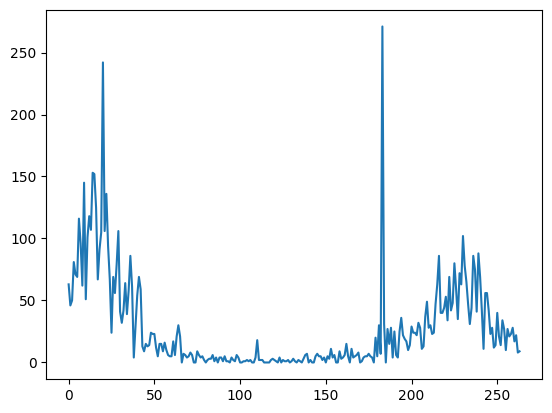

In [27]:
plt.plot([i for i in range(len(I))],I)

On estime le coefficient $\beta$ de la même manière que le coefficient $\gamma$, avec la zone d'intêret [190:232]

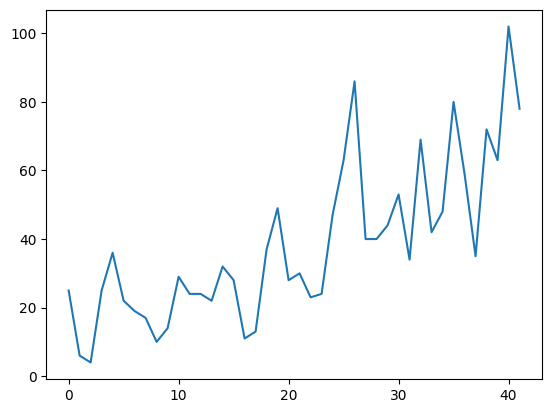

In [28]:
plt.plot([i for i in range(len(I[190:232]))],I[190:232])

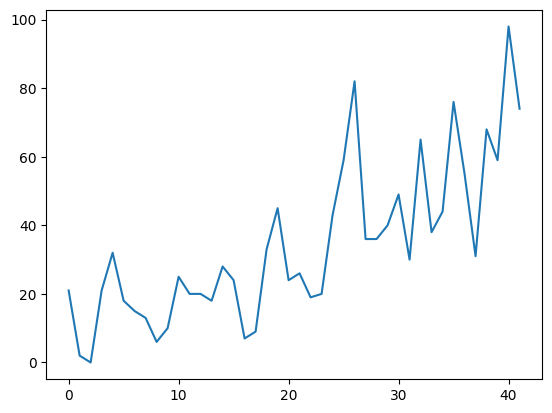

In [29]:
domaine_etude_beta = np.array(I[190:232])
domaine_etude_beta = domaine_etude_beta - np.min(domaine_etude_beta)
plt.plot([i for i in range(len(domaine_etude_beta))],domaine_etude_beta)
plt.show()

In [30]:
def courbe_exponentielle_croissante(param,n):
    Y = []
    for i in range(n):
        Y.append(np.exp(i*param))
    return(Y)

def distance(X,Y):
    return(np.sum((np.array(X)-np.array(Y))**2))

n = len(domaine_etude_beta)
min_dist = np.inf
min_param = 0
for i in range(1,10000):
    param = 0.0001*i
    Y = courbe_exponentielle_croissante(param,n)
    dist = distance(domaine_etude_beta,Y)
    if dist < min_dist:
        min_dist = dist
        min_param = param

print(min_param)

0.1119


On a ainsi estimé le paramètre $\beta$ qui vaut environ 0.1119 en Essonne.

#### Conclusion :

On a estimé que dans le département de l'Essonne, on obtient comme paramètres ($\beta$,$\gamma$) = (0.1119,0.0331).
Cela est cohérent avec l'épidémie de Covid, qui a explosé et donc le coefficient $\beta$ devait être nécessairement plus important que le coefficient $\gamma$. Si on en fait la simulation avec nos différents modèles, on obtient :

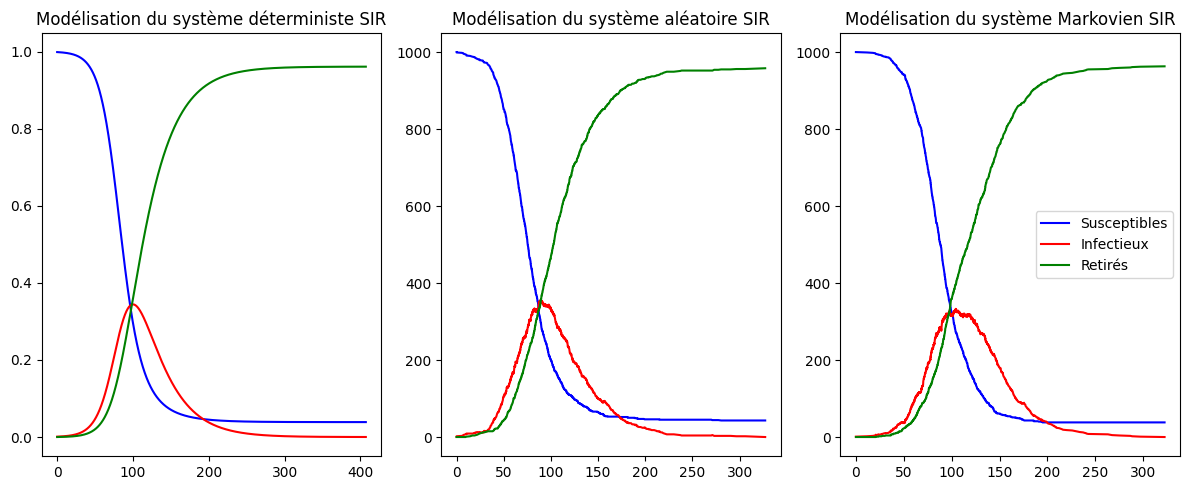

In [31]:
beta = 0.1119
gamma = 0.0331

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

liste_s,liste_i,liste_r,liste_temps = resolution_euler_deterministe(1-1/1000,1/1000,0,beta,gamma,0.01)
axes[0].plot(liste_temps,liste_s,label='Susceptibles',color='b')
axes[0].plot(liste_temps,liste_i,label='Infectieux',color='r')
axes[0].plot(liste_temps,liste_r,label='Retirés',color='g')
axes[0].set_title("Modélisation du système déterministe SIR")

liste_S,liste_I,liste_R,liste_T = simulation_SIR_aleatoire(1000,beta,gamma)
axes[1].plot(liste_T,liste_S,label='Susceptibles',color='b')
axes[1].plot(liste_T,liste_I,label='Infectieux',color='r')
axes[1].plot(liste_T,liste_R,label='Retirés',color='g')
axes[1].set_title("Modélisation du système aléatoire SIR")

liste_S,liste_I,liste_R,liste_T = simulation_markov(1000,beta,gamma)
axes[2].plot(liste_T,liste_S,label='Susceptibles',color='b')
axes[2].plot(liste_T,liste_I,label='Infectieux',color='r')
axes[2].plot(liste_T,liste_R,label='Retirés',color='g')
axes[2].set_title("Modélisation du système Markovien SIR")

plt.legend()
plt.tight_layout()
plt.show()

On observe bien que l'épidémie du Covid a touché la plupart de la population, car elle était en effet très infectieuse, et les périodes de gestation étaient grandes. Toutefois, il faut prendre du recul sur ce résultat, car une grande partie des personnes infectieuses étaient aussi asymptomatiques, et ne se sont pas présentées à l'hôpital, et à l'inverse un grand nombre de personnes n'ont pas été touchées par la maladie.

Le coefficient estimé $\beta$ est donc une sur-estimation du coefficient réel, puisque 100% des patients de l'hôpital ont été touchés.

On peut calculer le coefficient $R_0 = \frac{\beta}{\gamma}$ associé, qui devrait être entre 1 et 5 pour le COVID :

In [32]:
R0 = beta/gamma
print(f"R0 = {R0}")

R0 = 3.380664652567976


Le résultat est satisfaisant : en moyenne, un individu infectieux contamine 3.38 autres personnes avant d'être retiré.

___

# Fin du compte-rendu